In [4]:
import numpy as np
import pandas as pd
import cozmo
import cv2
import math
from cozmo.util import degrees, distance_mm, speed_mmps
from PIL import Image
import random


In [5]:
def compare_images(imageA, imageB):
  # See https://en.wikipedia.org/wiki/Mean_squared_error 
  dimensions = imageA.astype("float").shape
  width = dimensions[1]
  height = dimensions[0]
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  # Dividing the values so they fit 
  err /= (width * height * width * height)
  return err

In [6]:
iterations = 1

def demo(robot: cozmo.robot.Robot):
    robot.camera.image_stream_enabled = True
    for i in range(iterations):
        robot.turn_in_place(degrees(-10.0)).wait_for_completed()
        latest_image = robot.world.latest_image
        while latest_image is None:
            latest_image = robot.world.latest_image
            print("test")
        annotated = latest_image.annotate_image()
        if latest_image is not None:
            converted = annotated.convert()
            print("test2")
            converted.save("latestImage.jpeg", "JPEG", resolution=10)    


In [7]:
cozmo.run_program(demo)

TypeError: gather() got an unexpected keyword argument 'loop'

In [ ]:
img = Image.open("Panorama.jpeg")
image = cv2.resize(np.array(img), (320, 320))
compare_images(image, image)
#cv2.imshow("test", image)

NameError: name 'Image' is not defined

In [77]:
# Given a particle (position), get a image from the panorama centered on that position
def slice(pose, imageWidth):
    # initialize boundaries
    pano = Image.open("Panorama.jpeg")
    panoWidth, panoHeight = pano.size
    
    # Get initial bounds, regardless of if they are outside
    leftBound = pose - imageWidth / 2
    rightBound = pose + imageWidth / 2

    #initialize the final image
    sliced_image = None

    #if the left goes out of bounds
    if leftBound < 0:
        # the portion of the image that exceeds the left boundary and wraps to the right
        spillover_width = imageWidth / 2 - pose
        spillover_bounds = (panoWidth - spillover_width, 0, panoWidth, panoHeight)
        spillover_image = pano.crop(spillover_bounds)

        # the portion of the image that doesn't "spill over" across the left boundary
        unspilled_bounds = (0, 0, rightBound, panoHeight)
        unspilled_image = pano.crop(unspilled_bounds)

        #concactinate the two images together with spilled first then unspilled
        sliced_image = Image.new('RGB', (spillover_image.width + unspilled_image.width, panoHeight))
        sliced_image.paste(spillover_image, (0, 0))
        sliced_image.paste(unspilled_image, (spillover_image.width, 0))

        #save the img as a jpeg
        sliced_image.save("Sliced.jpeg")

    #if the right goes out of bounds
    elif rightBound > panoWidth:
        # the portion of the image that doesn't spill over the right boundary
        unspilled_bounds = (leftBound, 0, panoWidth, panoHeight)
        unspilled_image = pano.crop(unspilled_bounds)

        # the portion of the image that exceeds the right boundary and wraps back to the beginning
        spillover_width = imageWidth / 2 - (panoWidth - pose)
        spillover_bounds = (0, 0, spillover_width, panoHeight)
        spillover_image = pano.crop(spillover_bounds)

        #concactinate the two images together with unspilled first then spilled
        sliced_image = Image.new('RGB', (spillover_image.width + unspilled_image.width, panoHeight))
        sliced_image.paste(unspilled_image, (0, 0))
        sliced_image.paste(spillover_image, (unspilled_image.width, 0))

        #save the img as a jpeg
        sliced_image.save("Sliced.jpeg")
        
    else:
        # simple case, no spillover
        bounds = (leftBound, 0, rightBound, panoHeight)
        sliced_image = pano.crop(bounds)
        sliced_image = np.array(sliced_image)

        #save the img as a jpeg
        cv2.imwrite("Sliced.jpeg", sliced_image)

    return sliced_image

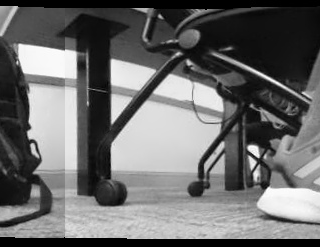

In [78]:
#Test of all three cases of slice, right out of bounds, left out of bounds, and somewhere in middle of pano
slice(1900, 320)
#slice(0, 320)
#slice(500, 320)

In [ ]:
sensorVariance = 0.01
proportionalMotionVariance = 0.01

def measurement_model(latestImage, particlePose):
    # Gaussian (i.e. normal) error, see https://en.wikipedia.org/wiki/Normal_distribution
    # same as p_hit in Figure 6.2(a), but without bounds. Table 5.2
  img = Image.open("Panorama.jpeg")
  width, height = img.size
  #get the slice of the panorama that corresponds to the pixel
  particle = slice(particlePose, 320)
  particle = np.array(particle)
  #resize the images
  cv_particle = cv2.resize(particle, (width, height))
  image2 = cv2.resize(latestImage, (width, height))
  #compare how similar/different they are using MSE
  diff = compare_images(cv_particle, image2)
  #see Text Table 5.2, implementation of probability normal distribution
  return (1.0 / math.sqrt(2 * math.pi * sensorVariance)) * math.exp(- (diff * diff) / (2 * sensorVariance))
def motion_model(movement, current_position, width):
  # making variance proportional to magnitude of motion command
  newX = current_position + movement + sample_normal_distribution(abs(movement * proportionalMotionVariance)) % width
  return newX % width
def sample_normal_distribution(variance):
  sum = 0
  for i in range(12):
    sum += (2.0 * random.random()) - 1.0
  return math.sqrt(variance) * sum / 2.0


In [ ]:
def localize(robot: cozmo.robot.Robot):
    #robot.camera.image_stream_enabled = True

    # load in panorama
    raw_panorama = cv2.imread("Panorama.jpeg")
    # get the width for determining movement
    width = raw_panorama.shape[1]

    # generate a (random) initial population of M possible positions
    M = 20
    particles = [] 
    for i in range(M):
        particles.append(random.randint(0, width))

    iterations = 1
    for i in range(iterations):
        latest_image = robot.world.latest_image
        while latest_image is None:
            latest_image = robot.world.latest_image
        annotated = latest_image.annotate_image()
        if latest_image is not None:
            converted = annotated.convert()
            converted.save("latestImage.jpeg", "JPEG", resolution=10)
        current_image = latest_image.annotate_image(scale=None, fit_size=None, resample_mode=0)
        np_curr_image = np.array(current_image)
    
        # Initialize arrays to store poses and corresponding weightws
        poses_and_weights = np.empty([M, 2])

        # for each possible position
        for p in range(M):
            currentPosition = particles[p]
            # update our belief about where the given pose represents, given the movement just made
            newPosition = motion_model(width / 36, currentPosition)
            # Assign a weight to this position based on the image difference
            weight = measurement_model(np_curr_image, newPosition) 

            # weight
            poses_and_weights[p] = [newPosition, weight]
        
        print(poses_and_weights)
        test = pd.DataFrame(poses_and_weights)
        print(poses_and_weights)
        test.to_csv("data.csv")

        # normalize the relative likelihoods
        total_weight = 0.0
        for i in range(M):
            total_weight += poses_and_weights[i, 1]


        


In [ ]:
cozmo.run_program(localize)

/home/bendurham441/.local/lib/python3.8/site-packages/cozmo/event.py:488: DeprecationWarning: The loop argument is deprecated since Python 3.8, and scheduled for removal in Python 3.10.
  return await asyncio.wait_for(f, timeout, loop=self._loop)
2023-04-14 13:56:07,514 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-14 13:56:07,514 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-14 13:56:07,514 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-14 13:56:07,514 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=00003.00004.00000
2023-04-14 13:56:07,514 cozmo.general INFO     App connection established. sdk_version=1.4.10 cozmoclad_version=3.4.0 app_build_version=0